# 02 - Cross-Validation & Data Splits

Visualize how we split the QQQ data for training.

**Time-Series Split:**
- Train: 2010-2021
- Validation: 2021-2022
- Test: 2022-2024

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)

print("✓ Imports successful")

✓ Imports successful


## Load Data

In [2]:
data = pd.read_parquet('demo_data/featured_data.parquet')

print(f"Total data: {len(data)} days")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")

Total data: 3574 days
Date range: 2010-10-18 to 2024-12-30


## Define Splits

In [3]:
# Test period: Recent 2 years
test_start = pd.Timestamp('2022-01-01')

train_val_data = data[data.index < test_start].copy()
test_data = data[data.index >= test_start].copy()

# Train/Val: 85/15 split
train_size = int(len(train_val_data) * 0.85)
train_data = train_val_data.iloc[:train_size]
val_data = train_val_data.iloc[train_size:]

print("Data Splits:")
print(f"  Train:      {len(train_data):5d} days | {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"  Validation: {len(val_data):5d} days | {val_data.index[0].date()} to {val_data.index[-1].date()}")
print(f"  Test:       {len(test_data):5d} days | {test_data.index[0].date()} to {test_data.index[-1].date()}")
print()
print(f"Train: {len(train_data)/len(data)*100:.1f}%")
print(f"Val:   {len(val_data)/len(data)*100:.1f}%")
print(f"Test:  {len(test_data)/len(data)*100:.1f}%")

Data Splits:
  Train:       2398 days | 2010-10-18 to 2020-04-28
  Validation:   424 days | 2020-04-29 to 2021-12-31
  Test:         752 days | 2022-01-03 to 2024-12-30

Train: 67.1%
Val:   11.9%
Test:  21.0%


## Visualize Splits


✓ Saved: demo_outputs/data_splits.png


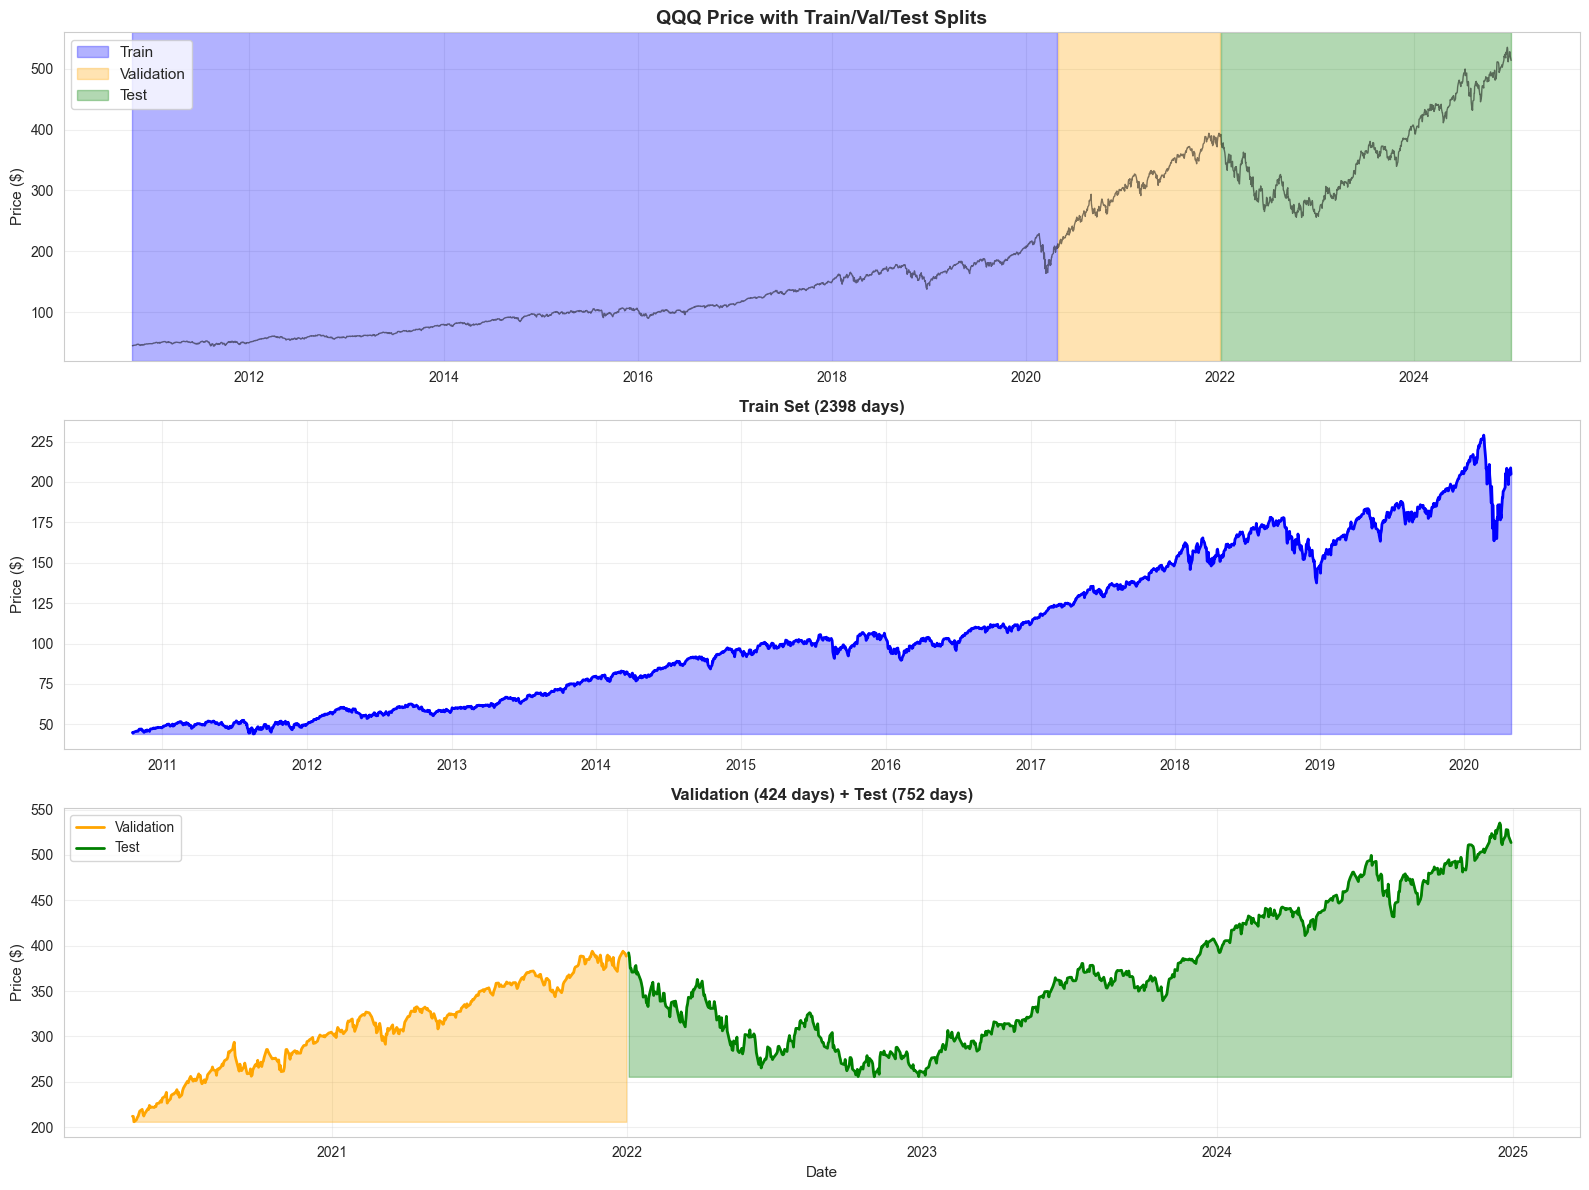

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Full timeline with splits
ax = axes[0]
ax.plot(data.index, data['close'], 'k-', linewidth=1, alpha=0.5)
ax.axvspan(train_data.index[0], train_data.index[-1], alpha=0.3, color='blue', label='Train')
ax.axvspan(val_data.index[0], val_data.index[-1], alpha=0.3, color='orange', label='Validation')
ax.axvspan(test_data.index[0], test_data.index[-1], alpha=0.3, color='green', label='Test')
ax.set_title('QQQ Price with Train/Val/Test Splits', fontsize=14, fontweight='bold')
ax.set_ylabel('Price ($)', fontsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

# Train set
ax = axes[1]
ax.plot(train_data.index, train_data['close'], 'b-', linewidth=2)
ax.fill_between(train_data.index, train_data['close'].min(), train_data['close'],
                alpha=0.3, color='blue')
ax.set_title(f'Train Set ({len(train_data)} days)', fontsize=12, fontweight='bold')
ax.set_ylabel('Price ($)', fontsize=11)
ax.grid(True, alpha=0.3)

# Val + Test sets
ax = axes[2]
ax.plot(val_data.index, val_data['close'], 'orange', linewidth=2, label='Validation')
ax.plot(test_data.index, test_data['close'], 'g-', linewidth=2, label='Test')
ax.fill_between(val_data.index, val_data['close'].min(), val_data['close'],
                alpha=0.3, color='orange')
ax.fill_between(test_data.index, test_data['close'].min(), test_data['close'],
                alpha=0.3, color='green')
ax.set_title(f'Validation ({len(val_data)} days) + Test ({len(test_data)} days)', fontsize=12, fontweight='bold')
ax.set_ylabel('Price ($)', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('demo_outputs/data_splits.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved: demo_outputs/data_splits.png")
plt.show()

## Returns Distribution by Split


Train Returns:
  Mean: 0.0007
  Std:  0.0121
  Min:  -0.1198
  Max:  0.0847

Validation Returns:
  Mean: 0.0015
  Std:  0.0130
  Min:  -0.0507
  Max:  0.0446

Test Returns:
  Mean: 0.0005
  Std:  0.0149
  Min:  -0.0548
  Max:  0.0738


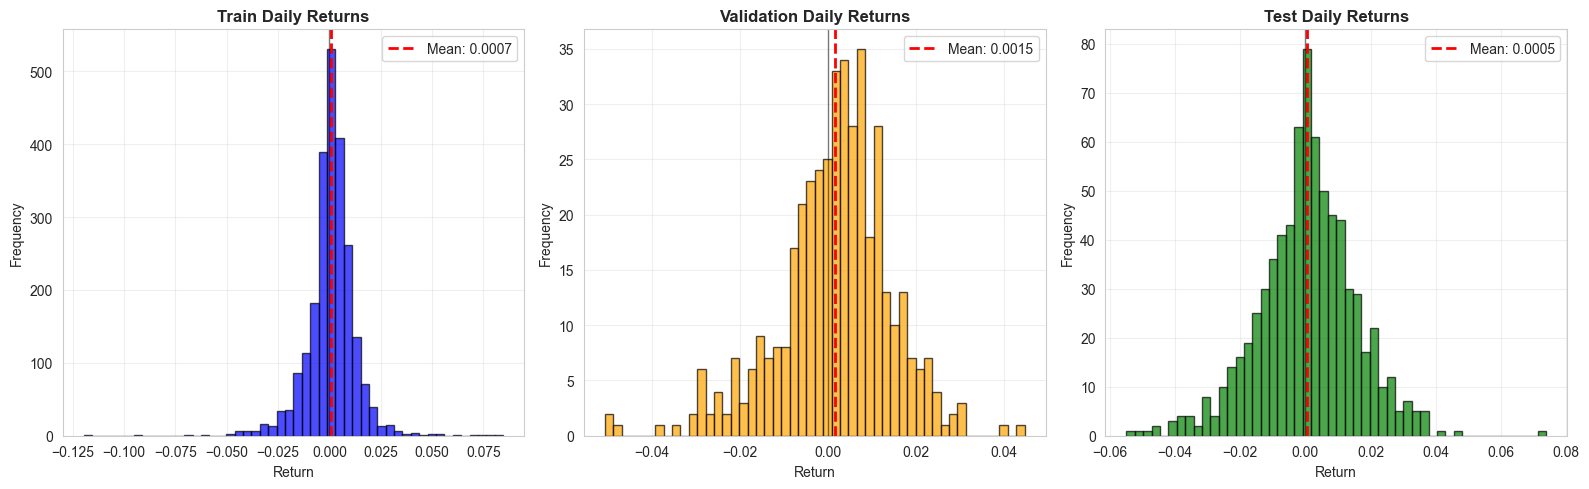

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

splits = [
    (train_data, 'Train', 'blue'),
    (val_data, 'Validation', 'orange'),
    (test_data, 'Test', 'green')
]

for ax, (split_data, name, color) in zip(axes, splits):
    returns = split_data['close'].pct_change().dropna()
    
    ax.hist(returns, bins=50, alpha=0.7, color=color, edgecolor='black')
    ax.axvline(returns.mean(), color='red', linestyle='--', linewidth=2,
              label=f'Mean: {returns.mean():.4f}')
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax.set_title(f'{name} Daily Returns', fontsize=12, fontweight='bold')
    ax.set_xlabel('Return')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Stats
    print(f"\n{name} Returns:")
    print(f"  Mean: {returns.mean():.4f}")
    print(f"  Std:  {returns.std():.4f}")
    print(f"  Min:  {returns.min():.4f}")
    print(f"  Max:  {returns.max():.4f}")

plt.tight_layout()
plt.show()

## Volatility by Split

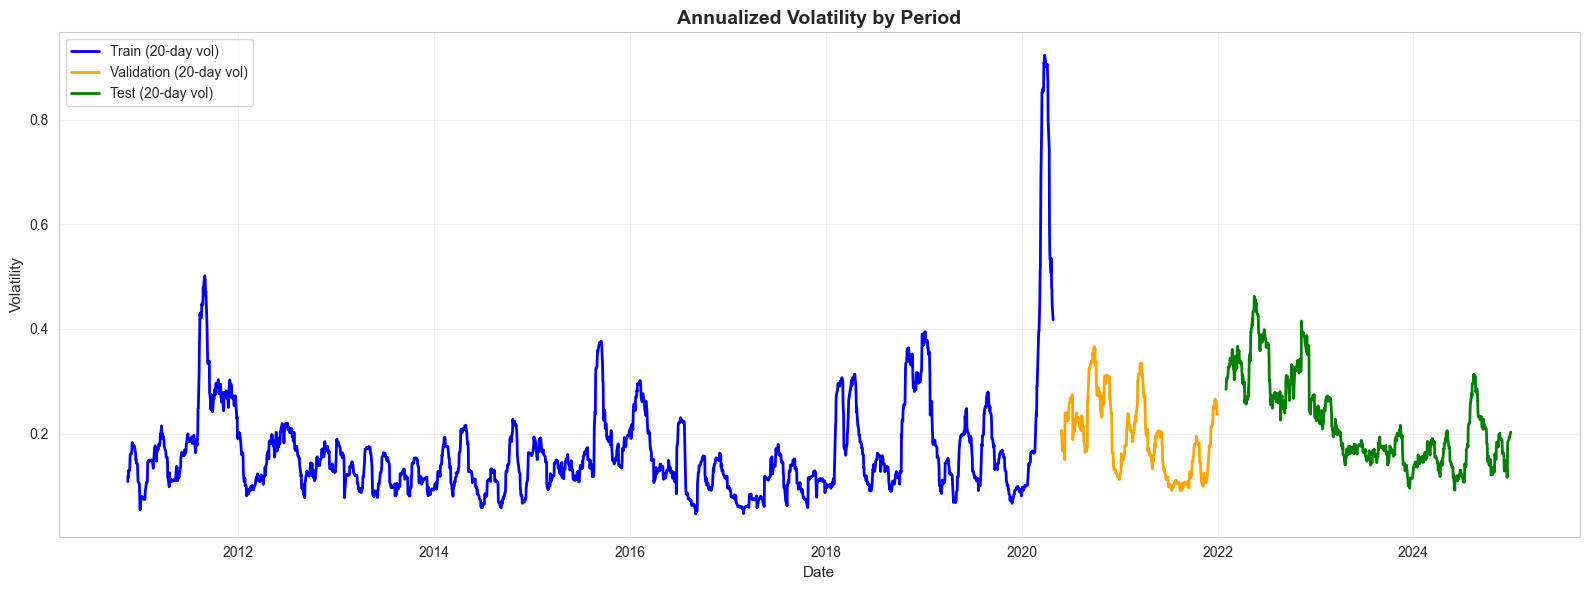

In [6]:
# Calculate rolling volatility for each split
fig, ax = plt.subplots(figsize=(16, 6))

for split_data, name, color in splits:
    returns = split_data['close'].pct_change()
    vol = returns.rolling(window=20).std() * np.sqrt(252)  # Annualized
    ax.plot(split_data.index, vol, linewidth=2, label=f'{name} (20-day vol)', color=color)

ax.set_title('Annualized Volatility by Period', fontsize=14, fontweight='bold')
ax.set_ylabel('Volatility', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

✅ Data properly split for time-series
✅ No data leakage (test set is future data)
✅ Validation set used for model selection
✅ Test set held out for final evaluation

**Next:** Run notebook **03** to train the aggressive agent!